In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Flatten

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [2]:
# Read in the dataset
data = pd.read_csv('MARA_DATA.csv', date_parser = True)
data.head(5)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2018-05-07T00:00:00.000Z,1.59,1.64,1.56,1.58,1022901,6.36,6.56,6.24,6.32,255725,0,1.0
1,2018-05-08T00:00:00.000Z,1.45,1.59,1.45,1.56,1709558,5.80,6.36,5.80,6.24,427389,0,1.0
2,2018-05-09T00:00:00.000Z,1.51,1.58,1.46,1.48,1169407,6.04,6.32,5.84,5.92,292351,0,1.0
3,2018-05-10T00:00:00.000Z,1.43,1.54,1.40,1.51,1111632,5.72,6.16,5.60,6.04,277908,0,1.0
4,2018-05-11T00:00:00.000Z,1.37,1.42,1.35,1.35,921190,5.48,5.68,5.40,5.40,230297,0,1.0


In [3]:
#Replace None or Null values with forward filling technique using fillna function.
data = data.fillna(method = 'ffill')

#Convert Date column into Datatime format
data['date'] = pd.to_datetime(data.date)

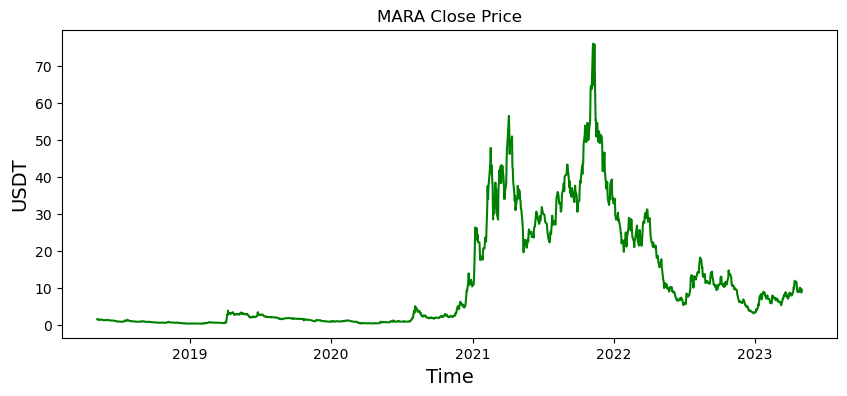

In [4]:
# Visualize the close price history
plt.figure(figsize=(10, 4))
plt.plot(data['date'], data['close'], color="green")
plt.title('MARA Close Price')
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

In [5]:
# Set date column as index
data.set_index("date", inplace=True) 

In [6]:
# calculate the number of rows in 80% of the data
n_rows = int(0.8 * len(data))

# select the first 80% of the data
train = data.iloc[:n_rows, :]

# calculate the number of rows in 20% of the data
n_rows = int(0.2 * len(data))

# select the first 20% of the data
test = data.iloc[:n_rows, :]

In [7]:
#feature selection
train = train.drop(['divCash', 'splitFactor'], axis = 1)
train.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume
date,,,,,,,,,,
2018-05-07 00:00:00+00:00,1.59,1.64,1.56,1.58,1022901,6.36,6.56,6.24,6.32,255725
2018-05-08 00:00:00+00:00,1.45,1.59,1.45,1.56,1709558,5.80,6.36,5.80,6.24,427389
2018-05-09 00:00:00+00:00,1.51,1.58,1.46,1.48,1169407,6.04,6.32,5.84,5.92,292351
2018-05-10 00:00:00+00:00,1.43,1.54,1.40,1.51,1111632,5.72,6.16,5.60,6.04,277908
2018-05-11 00:00:00+00:00,1.37,1.42,1.35,1.35,921190,5.48,5.68,5.40,5.40,230297


In [8]:
# Initialize the MinMaxScaler object to scale the input data to the range (0, 1)
scaler = MinMaxScaler()

# Use the scaler object to normalize the input data
train_scaled = scaler.fit_transform(train)

In [9]:
# Next, we initialize empty lists to hold the input sequences and target values
X_train = []
y_train = []

# We set the sequence length to 60 time steps
window_size = 60

# The number of features in the input data is obtained from the shape of the scaled input data
num_features = train_scaled.shape[1]

In [10]:
# We loop through the normalized input data, creating sequences of 60 time steps with the corresponding target value

for i in range(window_size, train_scaled.shape[0]):
    X_train.append(train_scaled[i-window_size:i])
    y_train.append(train_scaled[i,0])

In [11]:
# Convert the input sequences and target values to numpy arrays for training the neural network
X_train, y_train = np.array(X_train), np.array(y_train)

# Finally, we print the shapes of the input data and target values to verify that the data is in the correct format for training
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (944, 60, 10)
y_train:  (944,)


In [12]:
# We define a Sequential model and add a GRU layer with 50 units and 'tanh' activation function as the input layer. The input shape is set to (window_size, num_features) to match the format of the input data.
model = Sequential()
model.add(GRU(units=50, activation='tanh', input_shape=(window_size, num_features)))

# We add a Dense output layer with 1 unit to the model
model.add(Dense(1))

# We print the summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                9300      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 9,351
Trainable params: 9,351
Non-trainable params: 0
_________________________________________________________________


In [13]:
# We compile the model using the Adam optimizer and the mean squared error loss function
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# We train the model using the fit() function, passing in the input sequences (X_train) and target values (y_train) as well as the number of epochs and batch size
history = model.fit(X_train, y_train, epochs = 50, batch_size =32)

Epoch 1/50
30/30 [==============================] - 4s 4ms/step - loss: 0.0050
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 8.5409e-04
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 7.5545e-04
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 6.8511e-04
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 7.4700e-04
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 7.9739e-04
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 7.5143e-04
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 7.6667e-04
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 6.4658e-04
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 6.4398e-04
Epoch 11/50
30/30 [==============================] - 0s 4ms/step - loss: 6.9492e-04
Epoch 12/50
30/30 [==============================] - 0s 4ms/step - loss: 6.7392e-04
Epoch

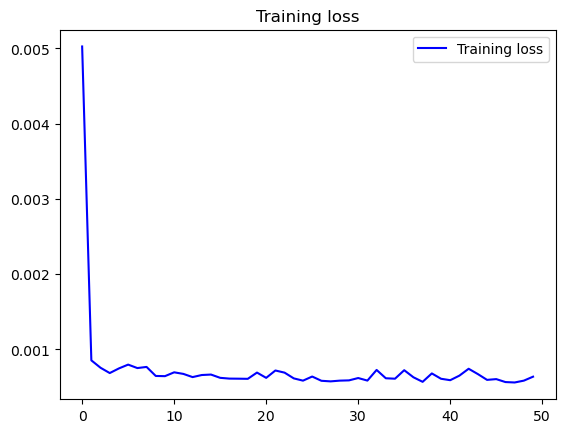

<Figure size 640x480 with 0 Axes>

In [14]:
# We first extract the training loss values from the `history` object returned by the `model.fit()` function.
loss = history.history['loss']

# We create a range object with the same length as the number of epochs.
epochs = range(len(loss))

# We plot the training loss as a function of the epochs using Matplotlib.
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()

# We display the plot.
plt.show()

In [15]:
# We drop some unnecessary columns from the test data.
test = test.drop(['divCash', 'splitFactor'], axis = 1)

# We normalize the test data using the same scaler that was used to normalize the training data.
test_scaled = scaler.transform(test)

In [16]:
# We create empty lists to store the input and output data.
X_test = []
y_test = []

# We loop through the test data and create input sequences and corresponding output values.
for i in range (window_size, test_scaled.shape[0]):
    X_test.append(test_scaled[i-window_size:i])
    y_test.append(test_scaled[i, 0])

In [17]:
# We convert the input and output data to NumPy arrays.
X_test, y_test = np.array(X_test), np.array(y_test)

# We print the shapes of the input and output data.
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_test:  (191, 60, 10)
y_test:  (191,)


In [18]:
# We use the trained model to make predictions on the test data.
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [19]:
# We compute the mean squared error between the true output values and the predicted output values.
mse = mean_squared_error(y_test, y_pred)

# We print the mean squared error.
print("MSE: {:.8f}".format(mse))


MSE: 0.00003054


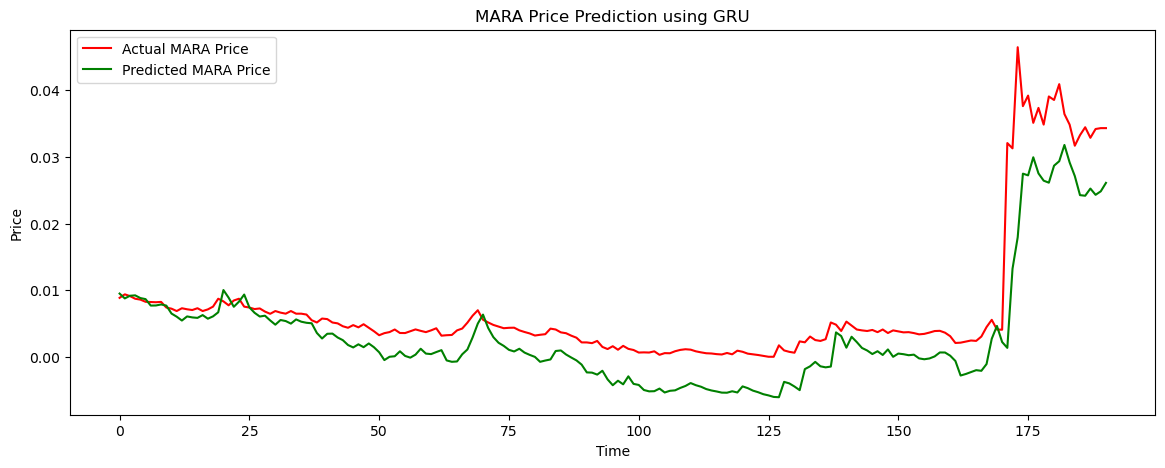

In [20]:
# We create a figure with a specific size.
plt.figure(figsize=(14,5))

# We plot the actual MARA prices in red and the predicted MARA prices in green.
plt.plot(y_test, color = 'red', label = 'Actual MARA Price')
plt.plot(y_pred, color = 'green', label = 'Predicted MARA Price')

# We add a title and axis labels to the plot.
plt.title('MARA Price Prediction using GRU')
plt.xlabel('Time')
plt.ylabel('Price')

# We add a legend to the plot.
plt.legend()

# We display the plot.
plt.show()